<a href="https://colab.research.google.com/github/erlichsefi/ScrapeAnything/blob/main/browser_base_translation%20/AutoJavaScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting sites to dataframe

# first: install selenium & chromium

In [ ]:
# According to: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.Lc1D1w8NDn/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.Ne6bnG7Xgw/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.xatqc4JB4k/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [ ]:
! apt install chromium-chromedriver
! pip install pandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  chromium-chromedriver
0 upgraded, 1 newly installed, 0 to remove and 52 not upgraded.
Need to get 2,496 B of archives.
After this operation, 77.8 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 chromium-chromedriver amd64 1:85.0.4183.83-0ubuntu0.20.04.3 [2,496 B]
Fetched 2,496 B in 0s (15.0 kB/s)
(Reading database ... 123206 files and directories currently installed.)
Preparing to unpack .../chromium-chromedriver_1%3a85.0.4183.83-0ubuntu0.20.04.3_amd64.deb ...
Unpacking chromium-chromedriver (1:85.0.4183.83-0ubuntu0.20.04.3) ...
dpkg: error processing archive /var/cache/apt/archives/chromium-chromedriver_1%3a85.0.4183.83-0ubuntu0.20.04.3_amd64.deb (--unpack):
 trying to overwrite '/usr/bin/chromedriver', which is also in package chromium-driver 90.0.4430.212-1~deb10u1
Errors were enc

In [ ]:
script_with_logs = """
// Get all elements in the HTML page
const elements = document.getElementsByTagName('*');

// Create an array to store the element details
const elementDetails = [];

// Iterate through each element
for (let i = 0; i < elements.length; i++) {
  const element = elements[i];

  // Get the bounding rectangle of the element
  const rect = element.getBoundingClientRect();

  // Get the text content of the element
  const textContent = element.textContent.trim();

  // Get the tooltip value if it exists
  const tooltip = element.hasAttribute('title') ? element.getAttribute('title') : '';

  // Store the element, its bounding rectangle, text content, and tooltip details
  const elementInfo = {
    element: element,
    rect: rect,
    textContent: textContent,
    ariaLabel: element.hasAttribute('aria-label') ? element.getAttribute('aria-label') : '',
    tooltip: tooltip,
    e_type: element.nodeName
  };
  if (elementInfo.rect.width > 0 && elementInfo.rect.height > 0){
  // Add the element details to the array
   if (elementInfo.tooltip != '' || elementInfo.textContent != '' || elementInfo.ariaLabel != ''){
    elementDetails.push(elementInfo);
    }
  }
}

let parents = elementDetails.map(e=>e.element.parentElement);
let withoutParents = elementDetails.filter(elementDetail=> !parents.includes(elementDetail.element));

// Display the element details
console.log("X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel");
console.log(withoutParents.map( e=> e.rect.x+","+e.rect.y+","+e.rect.width+","+e.rect.height+","+e.e_type+","+e.rect.textContent+","+e.tooltip+","+e.ariaLabel).join("\\n"));
"""

In [ ]:
def web_driver_to_image(wd,prefix=""):
  import re
  import os
  from urllib.parse import urlparse, urlunparse

  url = wd.current_url
  # Parse the URL
  parsed_url = urlparse(url)

  # Remove the query parameters
  clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""))

  print(clean_url)
  file_name = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_url)
  file_name = f"{prefix}{file_name}.png"

  wd.save_screenshot(file_name)
  return file_name

def screen_to_table(url):
  from selenium import webdriver
  from selenium.webdriver.chrome.service import Service
  import pandas as pd
  import io


  service = Service(executable_path=r'/usr/bin/chromedriver')
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.headless = True
  wd = webdriver.Chrome(service=service,options=chrome_options)
  wd.get(url)

  filename = web_driver_to_image(wd)
  #wd.title
  script = f"""
  var consoleLogs = [];
  var originalLog = console.log;
  console.log = function(message) {{
      consoleLogs.push(message);
      originalLog.apply(console, arguments);
  }};

  {script_with_logs}

  return consoleLogs;
  """

  logs = wd.execute_script(script)

  df = pd.read_csv(io.StringIO("\n".join(logs)), sep=",")

  return wd,df,filename


wd,df,file_name = screen_to_table('https://www.google.com')
df

<ipython-input-132-e78014f57e4d>:31: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


https://www.google.com/


,X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel
0,21.000000,17,46.593750,26,A,undefined,NaN,NaN
1,77.593750,17,43.468750,26,A,undefined,NaN,NaN
2,523.406250,18,33.953125,24,A,undefined,NaN,Gmail (opens a new tab)
3,572.359375,18,42.640625,24,A,undefined,NaN,Search for Images (opens a new tab)
4,634.000000,10,40.000000,40,A,undefined,NaN,Google apps
5,711.718750,22,44.562500,16,SPAN,undefined,NaN,NaN
6,264.000000,60,272.000000,92,DIV,undefined,NaN,NaN
7,123.000000,179,33.000000,46,DIV,undefined,NaN,NaN
8,156.000000,190,443.000000,27,TEXTAREA,undefined,Search,Search
9,603.000000,179,40.000000,44,DIV,undefined,NaN,Search by voice


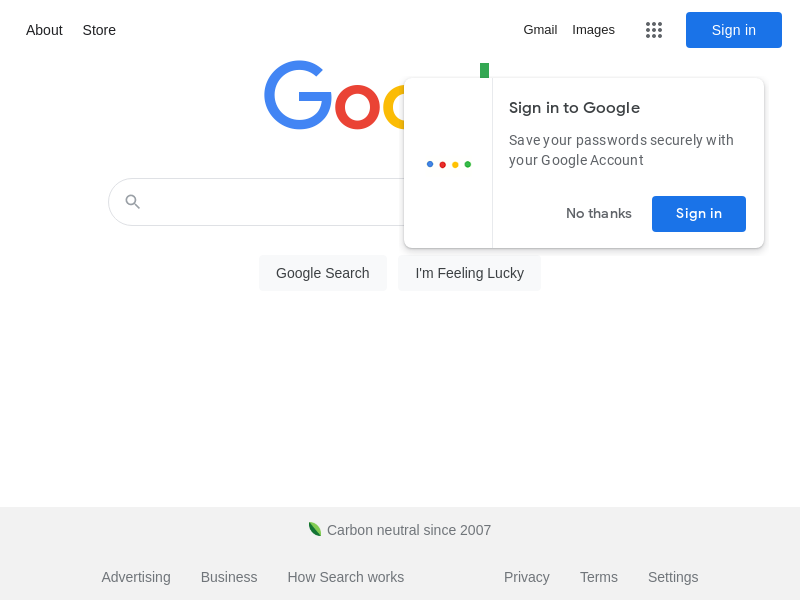

In [ ]:
from IPython.display import Image, display
display(Image(filename=file_name))

# Testing GPT
Now, let's ask the LLM about it.
I've ask ChatGPT offline, "What coordinates i should click?" It's said {"x": 523.406250, "y": 18}, let try it. Here is the screenshot.

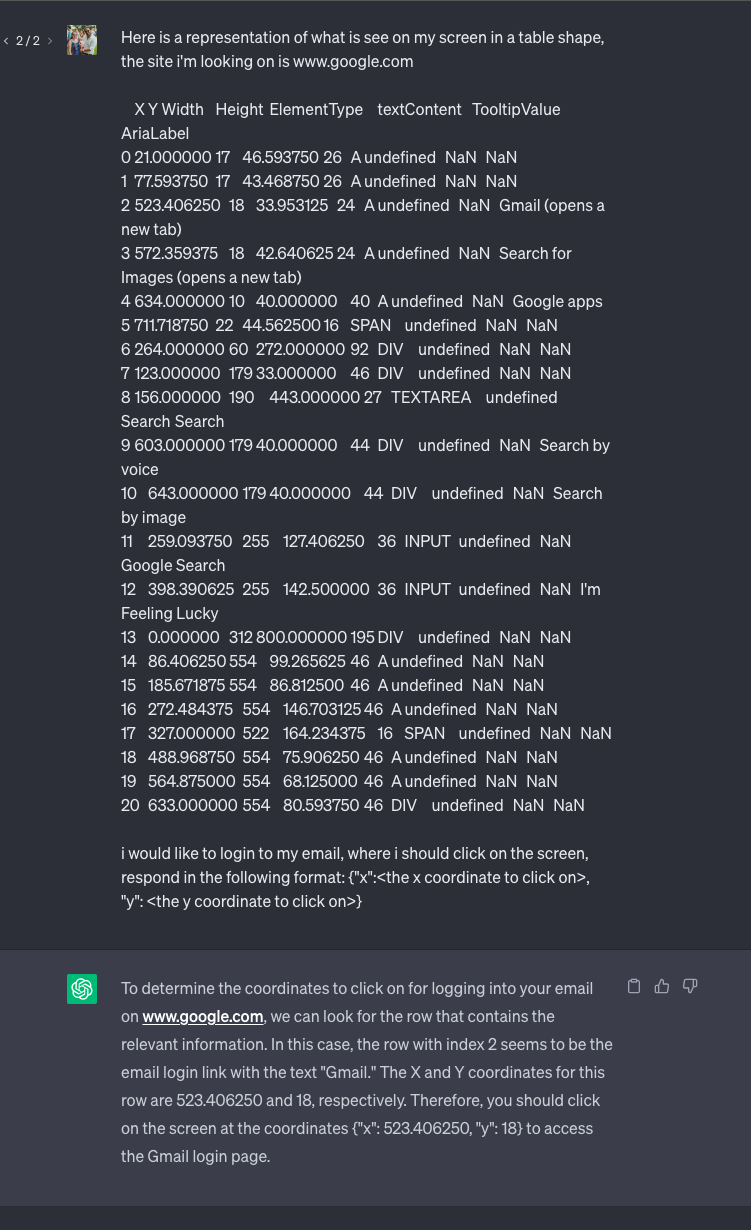

# Now let's see if he was correct

In [ ]:
from selenium.webdriver.common.action_chains import ActionChains
# Get X and Y coordinates

def draw_on_screen(filename,x,y):
  from PIL import Image, ImageDraw
  # Perform mouse click at X and Y coordinates
  # Open the screenshot image using Pillow
  image = Image.open(filename)

  # Create a drawing context on the image
  draw = ImageDraw.Draw(image)

  # Define the size of the marker
  marker_size = 10

  # Draw a marker at the specified coordinates
  draw.rectangle([(x - marker_size, y - marker_size), (x + marker_size, y + marker_size)], outline="red")

  # Save the marked screenshot
  image.save(f"click_location_{filename}")


def click_on_screen(wd,x,y):

  before_filename = web_driver_to_image(wd,"before_click_")
  draw_on_screen(before_filename,x,y)

  actions = ActionChains(wd)
  actions.move_by_offset(x, y)
  actions.click()
  actions.perform()
  after_filename = web_driver_to_image(wd,"after_click_")
  return before_filename,after_filename

before,after = click_on_screen(wd,524.406250,18)

https://www.google.com/
https://accounts.google.com/v3/signin/identifier


# Here is the before

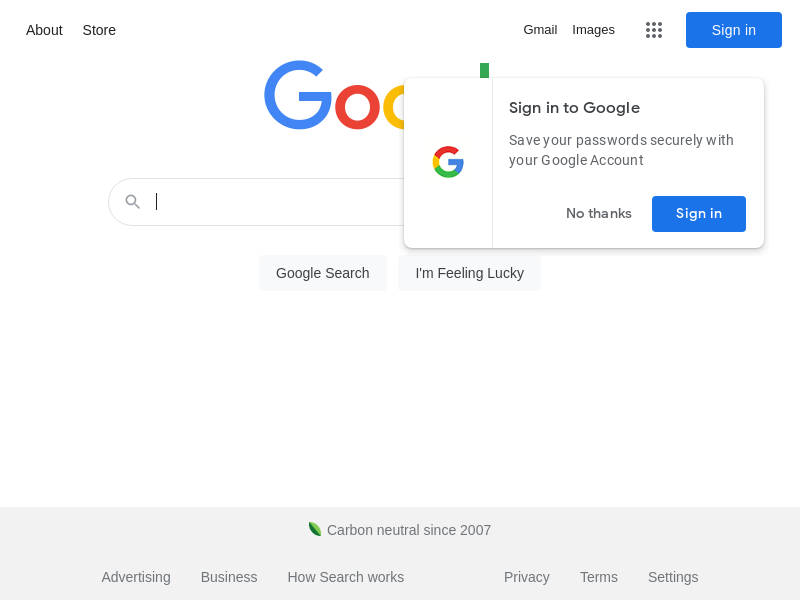

In [ ]:
from IPython.display import Image, display
display(Image(filename=before))

# Here is the after

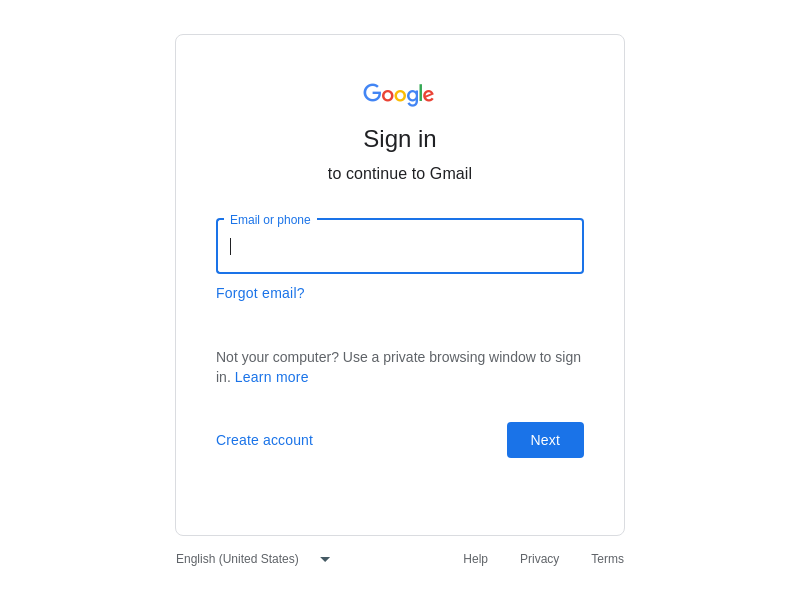

In [ ]:
from IPython.display import Image, display
display(Image(filename=after))